Yu-Chun Chen, A13356506  
Yanyu Tao, A13961185

## Mini-Project # 3

Is it more or less likely to be injured in a bike-related accident if you are on a bike path or not? How would the results differ for injuries of different severity, by zip codes, and by the type of other party in the accident? In which parts of the city is it more likely to get into an alcohol-related accident? How can you explain that using additional statistics by zip codes, for example, by the number of alcohol-serving bars in the zip code? 

Let's answer these questions using Arcgis API for Python. This is your third mini-project.

Recall the very first demo in the first lecture: we searched available content for "bike san diego", and found several layers or services, including collisions and bike routes. The collisions file showed bike and pedestrian TIMS-geocoded collisions in SD County (TIMS == Transpotation Injury Mapping System.) You can view the system description, including definitions of fields, at https://tims.berkeley.edu/help/SWITRS.php (SWITRS == Statewide Integrated Traffic Records System from CA Highway Patrol). There is a field indicating accidents that involved bicyclists. 

To answer the questions at the top of the cell, we'll need to integrate bike paths and accidents. But notice that the data we found through ArcGIS search during the first lecture, were for different times. So our first task is to grab more recent data and add it to the notebook you create. 

Your tasks, therefore, include:
1. Create an account at https://tims.berkeley.edu/, and sign in.
1. At SWITRS Query and Map, make a request for data from 1/1/2014 to 12/31/2018, for one or more cities in San Diego county (or just San Diego city.)  Specify that you are interested in bicycle collisions, and run the query.
1. Make sure that you get back 1000 or more records (e.g. if you select just San Diego city, you'd get 2289 total bicycle collisions). 
1. Download the collision data as a csv file, and explore it. Also, download party and victims data, because some attributes you'd need are in these files.
1. Explore the data you downloaded, and understand the fields you need to work with. See SWITRS FAQ page at https://tims.berkeley.edu/help/Query_and_Map.php#FAQs and the codebook at https://tims.berkeley.edu/help/SWITRS.php#Codebook. SWITRS is relatively well documented.
1. Find the field that is common for the 3 tables (this is what you can use to join them). Note, also, that there are similarly-named fields in the three tables, but they apply to different types. For example, "party sobriety" is a field in the "party" table (here, you can tell who in the collision was under the influence), while there is also an "alchohol involved" field in the collision table.
1. Read the collisions table into a Jupyter notebook, and create point map for it. Join other tables (possibly using group by) to this table. Also, save the table as a feature service into ArcGIS Online. 
1. Identify those collisions that happened along a bike path, and those that happened elsewhere. This may be tricky. Think about geometric meaning of "being on a bike path". Also, think which ArcGIS techniques you could use to connect data from the Collisions and the Bike Routes layers.
1. Summarize collisions by zip codes, and also add additional data to the zip codes table, using geoenrichment (you may want to look at variables in categories such as businesses, GroceryAlcoholicBeverages, LeisureActivitiesLifestyle, food). You may also use the businesses data you worked with in MP2. To find a zip codes feature layer or shapefile, search extarnal content on ArcGIS Online.
1. Do analysis of the collisions and zip codes layers, answering the questions at the top of this cell. Use a data analysis technique (eg regression) you learned in an earlier course. For example, you may use sklearn to build a model explaining severity of injuries as dependent on impairment, type of collision, and location. 

What you need to produce:
1. Map (or maps) of bicycle-related accidents and bike paths, where accidents are shown with different colors or symbols depending on whether a)alcohol was involved, b) the bicyclist was at fault because of impairment, and c) type of the other party in the accident.
2. Map by zip codes showing the alcohol-related bicycle accidents and one other variable by zip codes that may explain it (based on your findings)
3. Documented Jupyter Notebook with step-by-step analysis 
4. A brief description of findings (300 words or more)
5. URLs of resources you created on ArcGIS Online 

4. For extra credit: a) find additional interesting information by joining the victims table, b) how would you present these findings to a local planning commission that considers where to create bike paths avoiding areas that are prone to serious collisions? 


### Useful web sites about the problem:

* https://www.afr.com/lifestyle/cars-bikes-and-boats/cycling/where-most-car-and-bicycle-collisions-take-place-and-how-to-avoid-them-20161018-gs4ikm
* https://www.quora.com/How-do-most-vehicle-bicycle-collisions-occur
* https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3503407/
* https://cityroom.blogs.nytimes.com/2009/04/09/study-links-alcohol-and-bike-deaths/


In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point

In [2]:
import arcgis
from arcgis.gis import GIS
from arcgis import geometry
from arcgis.features import GeoAccessor, GeoSeriesAccessor
from arcgis.geocoding import geocode
from arcgis.geometry import lengths

In [3]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer

In [4]:
gis = GIS(username="yuc330_UCSDOnline9")  # this will ask for password. You can also include your password in this string
arcgis.__version__

Enter password: ········


'1.6.0'

In [5]:
# 1. Load the data (using concent manager, and also adding downloaded datasets), retain only fields we need
# You code goes here


In [5]:
# YOUR CODE HERE
collisions = pd.read_csv('Collisions.csv', low_memory = False)
parties = pd.read_csv('Parties.csv', low_memory = False)
victims = pd.read_csv('Victims.csv', low_memory = False)
#raise NotImplementedError()

In [6]:
collisions.shape

(2289, 80)

In [7]:
# 2. Joining party (and  victims, if going for extra credit) to collisions. 
# You code goes here


In [8]:
# YOUR CODE HERE
#merge all dataframes together according to CASE_ID
merged = collisions.merge(parties, on = 'CASE_ID')#.merge(victims, on = 'CASE_ID')
#raise NotImplementedError()

In [9]:
# 3. Clean spatial data as needed and create a point layer of collisions
# You code goes here


In [10]:
#Create sedf by longitude and latitude
merged['LONGITUDE'] = merged.apply(lambda x: x.POINT_X if pd.isnull(x.LONGITUDE) else x.LONGITUDE, axis = 1)
merged['LATITUDE'] = merged.apply(lambda x: x.POINT_Y if pd.isnull(x.LATITUDE) else x.LATITUDE, axis = 1)
sdf = pd.DataFrame.spatial.from_xy(merged, x_column = 'LONGITUDE', y_column = 'LATITUDE')

In [11]:
#replace null values with empty string
sdf['ALCOHOL_INVOLVED'] = sdf['ALCOHOL_INVOLVED'].replace(np.nan, 'N', regex = True)
sdf1 = sdf.replace(np.nan, '', regex = True)

In [16]:
#create feature layer for collision points
sdf_layer = sdf1.spatial.to_featurelayer(title = 'bike collisions', gis = gis)
sdf_layer.share(org = True)

{'results': [{'itemId': '52df59d462664cd982d6f30cdd4f0388',
   'notSharedWith': [],
   'success': True}]}

In [14]:
# YOUR CODE HERE
#raise NotImplementedError()

In [15]:
# 4. Define what you mean to be on a bike route, 
# and figure out, for each collision, whether it happened on a bike route or not. 
# Summarize collisions of different types by zip codes.
# You code goes here


<Item title:"Bike Routes" type:Feature Layer Collection owner:SD_Ocean_Planning_Partnership>
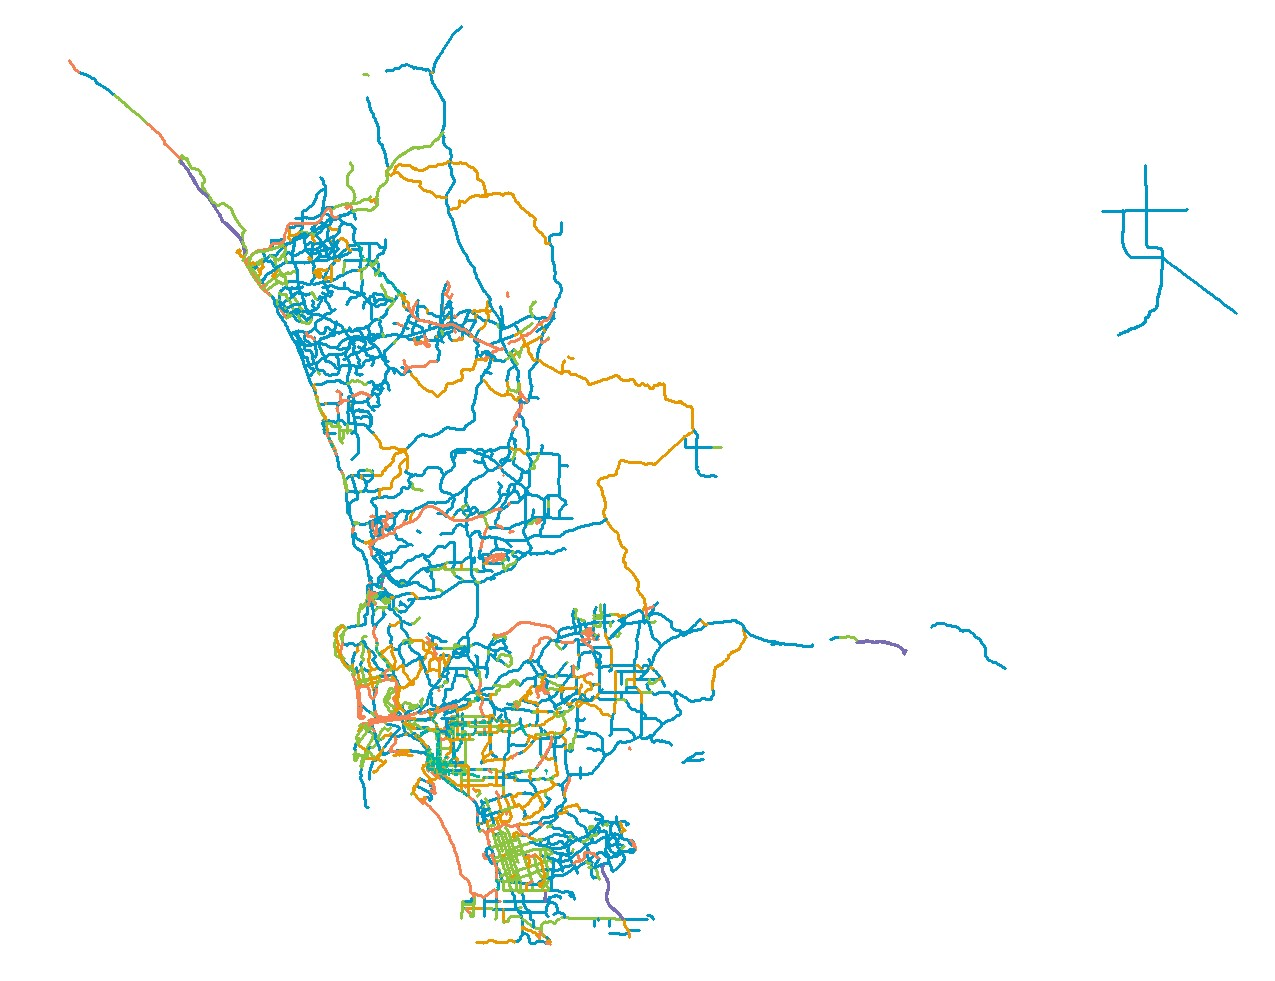

In [19]:
# YOUR CODE HERE
#search for bike route layer
result = gis.content.search('title: Bike Routes San Diego owner: SD_Ocean_Planning_Partnership' , item_type="Feature Layer", outside_org=True, max_items=50)
# sdf = SpatialDataFrame(afribat_data)
from IPython.display import display
for item in result:
    display(item)
#raise NotImplementedError()

<Item title:"Bike Routes" type:Feature Layer Collection owner:SD_Ocean_Planning_Partnership>
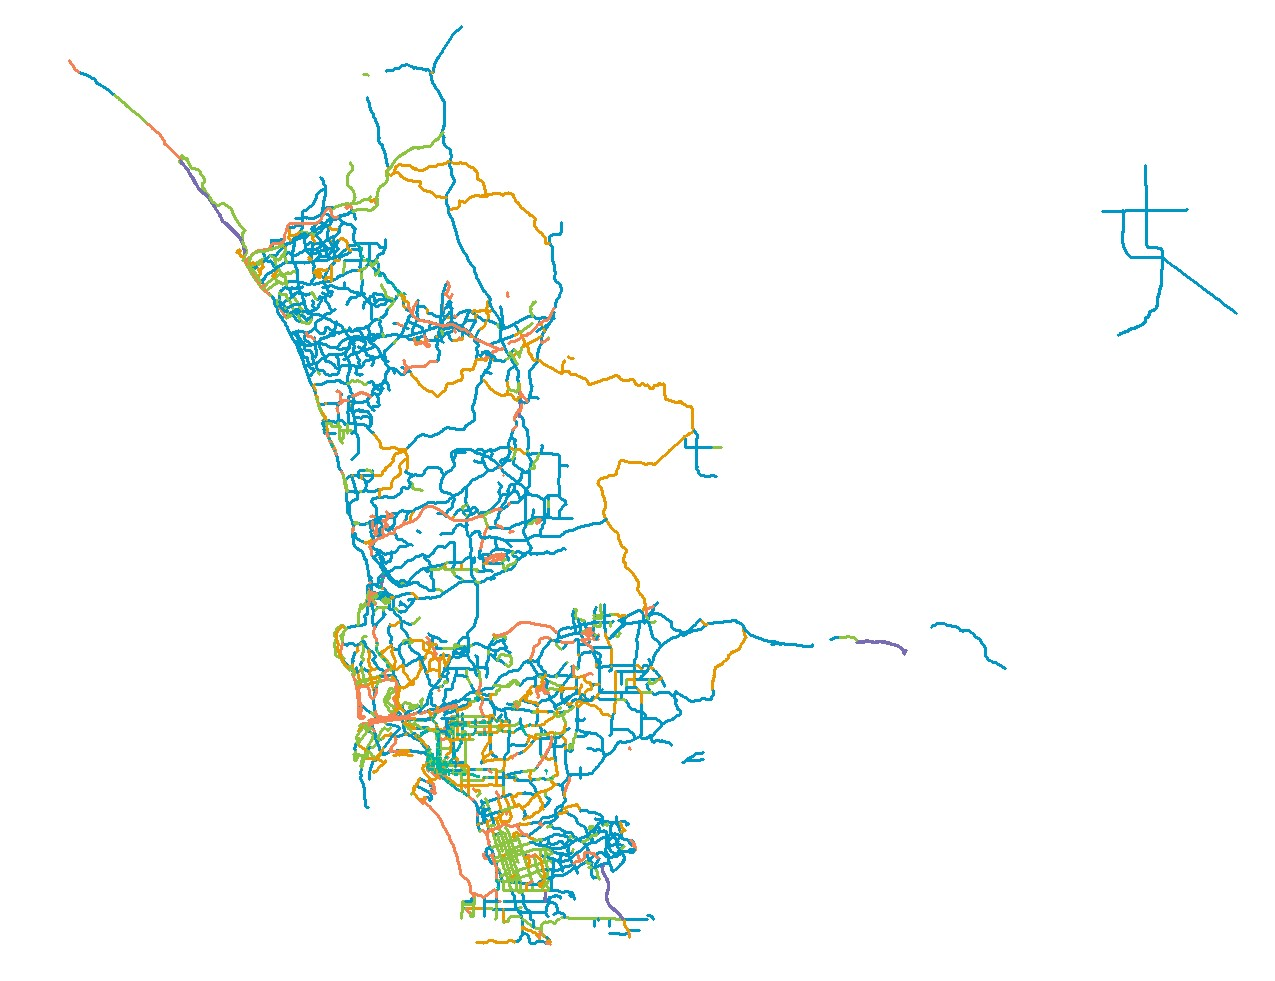

In [20]:
#bike route layer
bike_route = result[0]
bike_route

In [18]:
map1 = gis.map()

In [19]:
#show map of both bike route layer and collision points layer
location = geocode('San Diego')[0]
map1.extent = location['extent']
map1.zoom = 10
map1.height = '650px'
map1.add_layer(bike_route)
map1.add_layer(sdf_layer.layers[0])
map1

MapView(layout=Layout(height='400px', width='100%'), zoom=10.0)

In [18]:
#convert to df using layers
bike_route_df = pd.DataFrame.spatial.from_layer(bike_route.layers[0])
collisions_df = pd.DataFrame.spatial.from_layer(sdf_layer.layers[0])

In [17]:
from arcgis.features.find_locations import find_existing_locations

In [22]:
#find collisions that happen within 2 meters of a bike route (as California bike routes usually have minimum width of 4 to 6 feet)
collisionbikeroute = find_existing_locations(input_layers=[{'url': sdf_layer.layers[0].url},{'url': bike_route.layers[0].url}],
                                         expressions=[{"operator":"","layer":0,"selectingLayer":1,
                                                       "spatialRel":"withinDistance","distance":2,"units":"Meters"}],
                       output_name = 'collisionbikeroute31')

In [23]:
collisionbikeroute.share(org = True)

{'results': [{'itemId': '8400be097ec8492baa044c20859deb4d',
   'notSharedWith': [],
   'success': True}]}

In [23]:
#create df for collisions on bike routes from its layer
cb_df = pd.DataFrame.spatial.from_layer(collisionbikeroute.layers[0])

In [24]:
#add a column in previously merged df to identify if the collision happens on a bike route
cb_df['collisions on bike route'] = pd.Series([1]*len(cb_df))
identified = cb_df.merge(sdf1, on = 'CASE_ID', how = 'outer')
identified['collisions on bike route'] = identified['collisions on bike route'].replace(np.nan, 0)

In [25]:
#calculate percentage of collisions that happen on a bike route
collisions_on_bikeroutes_case_rate = len(cb_df.CASE_ID.unique())/len(identified.CASE_ID.unique())
collisions_on_bikeroutes_case_rate

0.272608125819135

<Item title:"San Diego County Zip Codes" type:Feature Layer Collection owner:Rizbee>
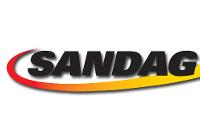

In [19]:
#search for ZIP codes layer
search = gis.content.search('title: San Diego County Zip Codes SANDAG owner: Rizbee', item_type="Feature Layer", outside_org=True, max_items=50)
for item in search:
    display(item)

<Item title:"San Diego County Zip Codes" type:Feature Layer Collection owner:Rizbee>
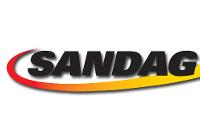

In [20]:
zip_layer = search[0]
zip_layer

In [28]:
#show the map for collisions in each zip codes
map2 = gis.map()
location = geocode('San Diego')[0]
map2.extent = location['extent']
map2.zoom = 10
map2.height = '650px'
map2.add_layer(zip_layer.layers[0])
map2.add_layer(sdf_layer.layers[0])
map2

MapView(layout=Layout(height='400px', width='100%'), zoom=10.0)

In [21]:
zip_df = pd.DataFrame.spatial.from_layer(zip_layer.layers[0])
collision_zip = zip_df.spatial.join(collisions_df.drop_duplicates(subset=['CASE_ID']))

In [26]:
#Find collisions that are fatal or severely injured by ZIP code

severe_collisions = sdf1.copy()[(sdf1['COLLISION_SEVERITY'] == 1) | (sdf1['COLLISION_SEVERITY'] == 2)]
severe_collisions['ZIP'] = collision_zip['ZIP']
severe_collisions['ZIP'].value_counts(normalize = True)

92105.0    0.150685
92109.0    0.130137
92101.0    0.130137
92115.0    0.068493
92126.0    0.061644
92102.0    0.047945
92123.0    0.041096
92121.0    0.041096
92104.0    0.041096
92103.0    0.034247
92037.0    0.034247
92113.0    0.027397
92111.0    0.027397
92110.0    0.027397
92116.0    0.027397
92107.0    0.020548
92117.0    0.020548
92120.0    0.020548
92173.0    0.013699
92106.0    0.013699
92118.0    0.006849
92129.0    0.006849
92154.0    0.006849
Name: ZIP, dtype: float64

##### Map by ZIP codes showing the alcohol-related bicycle accidents

In [12]:
#create a feature layer for alcohol-related bicycle accidents
alcohol_collisions = sdf1.copy()[sdf1['ALCOHOL_INVOLVED'] == 'Y']
alcohol_layer = alcohol_collisions.spatial.to_featurelayer(title = 'bike collisions alcohol involved', gis = gis)
alcohol_layer.share(org = True)

{'results': [{'itemId': '80b622f0adc2469b8ba99927637d5946',
   'notSharedWith': [],
   'success': True}]}

In [30]:
#map by zip codes showing the alcohol-related bicycle accidents
map6 = gis.map()
location = geocode('San Diego')[0]
map6.extent = location['extent']
map6.zoom = 10
map6.height = '650px'
map6.add_layer(zip_layer.layers[0])
map6.add_layer(alcohol_layer.layers[0])
map6

MapView(layout=Layout(height='400px', width='100%'), zoom=10.0)

In [42]:
#see the percentage of alcohol-related collisions in each Zip code area
collision_zip[collision_zip['ALCOHOL_IN'] == 'Y'].drop_duplicates(subset=['CASE_ID'])['ZIP'].value_counts(normalize = True)

92109    0.239130
92101    0.103261
92110    0.070652
92104    0.065217
92107    0.048913
92115    0.043478
92102    0.043478
92105    0.043478
92154    0.032609
92113    0.032609
92037    0.027174
92111    0.027174
92117    0.027174
92116    0.021739
92103    0.021739
92123    0.021739
92108    0.016304
92120    0.010870
92106    0.010870
92093    0.010870
92128    0.010870
92126    0.010870
92122    0.010870
92114    0.010870
92131    0.005435
92145    0.005435
92136    0.005435
92139    0.005435
92121    0.005435
92182    0.005435
92173    0.005435
Name: ZIP, dtype: float64

##### Map by ZIP codes showing the drug-related bicycle accidents

In [15]:
#create a feature layer for drug-related bicycle accidents
drug_collisions = sdf1.copy()[(sdf1['PARTY_DRUG_PHYSICAL'] == 'E') | (sdf1['PARTY_DRUG_PHYSICAL'] == 'F')]
drug_layer = drug_collisions.spatial.to_featurelayer(title = 'bike collisions drug involved', gis = gis)
drug_layer.share(org = True)

{'results': [{'itemId': '108cb2d667884d72be1371d733695e29',
   'notSharedWith': [],
   'success': True}]}

In [32]:
#map by zip codes showing the drug-related bicycle accidents
map7 = gis.map()
location = geocode('San Diego')[0]
map7.extent = location['extent']
map7.zoom = 10
map7.height = '650px'
map7.add_layer(zip_layer.layers[0])
map7.add_layer(drug_layer.layers[0])
map7

MapView(layout=Layout(height='400px', width='100%'), zoom=10.0)

In [43]:
#try to classify zip code areas by finding the business categories that the area has most 
sd_business = pd.read_csv('sd_businesses_active_since08_datasd.csv')
sd_business['ZIP'] = sd_business.zip.str[:5]
cat_zip = sd_business[sd_business['ZIP'] != 'J5B -'].groupby('ZIP').apply(lambda x: x['naics_description'].value_counts().idxmax())


In [44]:
#merge collisions data with categorized zip area information (with info of the business type that the area has the mostㄖ)
cat_zip = cat_zip.to_frame().reset_index()
cat_zip = cat_zip.rename({0:'type'}, axis = 1)
collision_zip['ZIP'] = collision_zip['ZIP'].astype(str)
categorized = collision_zip.merge(cat_zip, on = 'ZIP', how = 'left')

In [45]:
#percentage of bike collisions happen in each ZIP code areas
categorized.drop_duplicates(subset=['CASE_ID'])['ZIP'].value_counts(normalize = True)

92109    0.123316
92101    0.115544
92105    0.065285
92104    0.055440
92037    0.048187
92110    0.047668
92115    0.041451
92102    0.036788
92103    0.035751
92107    0.035233
92126    0.033161
92154    0.032124
92111    0.031606
92117    0.028497
92113    0.026943
92123    0.023834
92116    0.022798
92121    0.021244
92130    0.020725
92108    0.019689
92106    0.018135
92122    0.015026
92114    0.014508
92129    0.012953
92120    0.009326
92128    0.009326
92127    0.007254
92014    0.006736
92124    0.006218
92093    0.005699
92119    0.005181
92131    0.005181
92139    0.004145
92173    0.004145
92145    0.003109
92182    0.002591
92136    0.002591
92067    0.000518
91911    0.000518
92118    0.000518
91942    0.000518
92020    0.000518
Name: ZIP, dtype: float64

In [46]:
#percentage of bike collisions happen in each type of zip code areas (classified by the business type that the areas has most)
categorized.drop_duplicates(subset=['CASE_ID']).groupby('type')['CASE_ID'].count()/1925

type
ALL OTHER PERSONAL SERVICES                      0.169351
BUILDING, DEVELOPING & GENERAL CONTRACTING       0.001039
BUSINESS TAX EXEMPT - NON PROFIT                 0.023896
CLOTHING & CLOTHING ACCESSORIES STORES           0.004156
CONSULTING SERVICES                              0.104416
FULL-SERVICE RESTAURANTS                         0.062338
INDEPENDENT ARTISTS, WRITERS & PERFORMERS        0.082597
JANITORIAL SERVICES                              0.218701
LIMITED-SERVICE EATING PLACES                    0.005714
MANAGEMENT, SCI & TECH CONSULTING SERVICES       0.007273
MISCELLANEOUS STORE RETAILERS                    0.002597
OFFICES OF LAWYERS                               0.135584
PROFESSIONAL, SCIENTIFIC & TECHNICAL SERVICES    0.048312
REAL ESTATE                                      0.000519
RESIDENTIAL BUILDING CONSTRUCTION                0.000519
SCIENTIFIC R&D SERVICES                          0.021299
SWAP MEET VENDOR                                 0.080000
USED CAR 

In [47]:
# 5. Generate maps
# You code goes here


In [ ]:
# YOUR CODE HERE
#raise NotImplementedError()

##### Map of bicycle-related accidents and bike paths, where accidents are shown with different colors or symbols depending on whether ALCOHOL WAS INVOLVED

In [48]:
#map of bike collisions depending on whether alcohol was involved
gis = GIS()
map3 = gis.map('San Diego', zoomlevel=10) 
renderer = {"renderer": "autocast", "type": "uniqueValue", "field1":"ALCOHOL_IN"}

renderer["uniqueValueInfos"] = [{  "value": "Y",
                                    "symbol" : {"angle":0,"xoffset":0,"yoffset":0,"type":"esriPMS","url":"http://static.arcgis.com/images/Symbols/PeoplePlaces/Bar.png","contentType":"image/png","width":12,"height":12},
                                        "label": "Y"
                                    },
                                    {   "value": "N",
                                        "symbol" : {"angle":0,"xoffset":0,"yoffset":12,"type":"esriPMS","url":"http://static.arcgis.com/images/Symbols/Basic/WhiteStickpin.png","contentType":"image/png","width":12,"height":12},
                                        "label": "Blank"
                                    }]
map3.add_layer(sdf_layer.layers[0],
               { "type": "FeatureLayer",
                 "renderer": renderer,
                 "field_name":"ALCOHOL_IN"})

map3

MapView(layout=Layout(height='400px', width='100%'), zoom=10.0)

##### Map of bicycle-related accidents and bike paths, where accidents are shown with different colors or symbols depending on whether the bicyclist was at fault because of impairment (which is none)

In [12]:
#create feature layer for those at fault and also impaired
at_fault = sdf1.copy()[sdf1["AT_FAULT"]=="Y"]
at_fault["IMPAIRMENT"] = at_fault.apply(lambda x: 1 if x.PARTY_DRUG_PHYSICAL == "F" else 0, axis=1)
at_fault_layer = at_fault.spatial.to_featurelayer(title ='at fault impairment', gis=gis)
at_fault_layer.share(org = True)

{'results': [{'itemId': 'd1e8cac9bc3c495cb52fa078dba677f7',
   'notSharedWith': [],
   'success': True}]}

In [13]:
map8 = gis.map('San Diego')
location = geocode('San Diego')[0]
map8.extent = location['extent']
map8.zoom = 10
map8.height = '650px'



renderer_impair = {"renderer": "autocast", "type": "uniqueValue", "field1":"IMPAIRMENT"}

renderer_impair["uniqueValueInfos"] = [{  "value": "1",
                                        "symbol":  {"angle":0,"xoffset":0,"yoffset":0,"type":"esriPMS","url":"http://static.arcgis.com/images/Symbols/Transportation/SkullandCrossbones.png","contentType":"image/png","width":12,"height":12},
                                        "label": "because of impairment"
                                    },
                                    {   "value": "0",
                                        "symbol": {"angle":0,"xoffset":0,"yoffset":10,"type":"esriPMS","url":"http://static.arcgis.com/images/Symbols/Shapes/OrangePin1LargeB.png","contentType":"image/png","width":12,"height":12},
                                        "label": "not because of impairment"
                                    }]
map8.add_layer(at_fault_layer,
               { "type": "FeatureLayer",
                 "renderer": renderer_impair,
                 "field_name":"IMPAIRMENT"})

In [14]:
map8

MapView(layout=Layout(height='400px', width='100%'), zoom=10.0)

##### Map of bicycle-related accidents and bike paths, where accidents are shown with different colors or symbols depending on type of the other party in the accident

We classify accidents with only one person and accidents with three or more people involved as their own types. For accidents with exactly two people involved, we use the type of person involved (other than one bicyclist) as their types.

In [13]:
import copy

In [14]:
#map of bike collisions depending on the type of the other party

#classify the other party
s = sdf1.groupby('CASE_ID').apply(lambda x: x.PARTY_TYPE.tolist())

def filter_party(lst):
    if len(lst) == 1: #self crash
        return '100'
    elif len(lst) >= 3: #collisions with more than two parties
        return '300'
    else:
        co = copy.deepcopy(lst)
        co.remove('4')
        return co[0]

other_frame = s.apply(filter_party).to_frame().reset_index().rename({0:'the_other'}, axis = 1)
with_other = sdf1.merge(other_frame, on = 'CASE_ID').drop_duplicates(subset = ['CASE_ID'])
other_type_layer = with_other.spatial.to_featurelayer(title = 'bike collisions other party type', gis = gis)
other_type_layer.share(org = True)

{'results': [{'itemId': 'd850b07307774c60964ecc0b7017d16a',
   'notSharedWith': [],
   'success': True}]}

In [16]:
#draw the map
gis = GIS()
map5 = gis.map('San Diego', zoomlevel=10) 
renderer3 = {"renderer": "autocast", "type": "uniqueValue", "field1":"the_other"}

renderer3["uniqueValueInfos"] = [{  "value": "1",
                                    "symbol" : {"angle":0,"xoffset":0,"yoffset":0,"type":"esriPMS","url":"http://static.arcgis.com/images/Symbols/Transportation/TrafficAccident.png","contentType":"image/png","width":12,"height":12},
                                        "label": "driver"
                                    },
                                    {   "value": "2",
                                        "symbol" : {"angle":0,"xoffset":0,"yoffset":0,"type":"esriPMS","url":"https://static.arcgis.com/images/Symbols/NPS/Walking_1.png","contentType":"image/png","width":12,"height":12},
                                        "label": "pedestrian"
                                    },
                                    {  "value": "3",
                                    "symbol" : {"angle":0,"xoffset":0,"yoffset":0,"type":"esriPMS","url":"http://static.arcgis.com/images/Symbols/Transportation/RoadWork.png","contentType":"image/png","width":12,"height":12},
                                        "label": "parked vehicle"
                                    },
                                    {   "value": "4",
                                        "symbol" :  {"angle":0,"xoffset":0,"yoffset":0,"type":"esriPMS","url":"http://static.arcgis.com/images/Symbols/Transportation/esriDefaultMarker_189_Red.png","contentType":"image/png","width":12,"height":12},
                                        "label": "bicyclist"
                                    },
                                    {  "value": "5",
                                    "symbol" : {"angle":0,"xoffset":0,"yoffset":8.15625,"type":"esriPMS","url":"http://static.arcgis.com/images/Symbols/AtoZ/blueO.png","contentType":"image/png","width":7.5,"height":10.5},
                                        "label": "other"
                                    },
                                    {   "value": "-",
                                        "symbol" : {"angle":0,"xoffset":0,"yoffset":0,"type":"esriPMS","url":"http://static.arcgis.com/images/Symbols/Basic/CircleX.png","contentType":"image/png","width":12,"height":12},
                                        "label": "not stated"
                                    },
                                    {  "value": "100",
                                    "symbol" : {"angle":0,"xoffset":0,"yoffset":8.15625,"type":"esriPMS","url":"http://static.arcgis.com/images/Symbols/AtoZ/greenS.png","contentType":"image/png","width":7.5,"height":10.5},
                                        "label": "self crash"
                                    },
                                    {   "value": "300",
                                        "symbol" : {"angle":0,"xoffset":0,"yoffset":0,"type":"esriPMS","url":"http://static.arcgis.com/images/Symbols/PeoplePlaces/Crowd.png","contentType":"image/png","width":12,"height":12},
                                        "label": "crash of more than two"
                                    }]
map5.add_layer(other_type_layer.layers[0],
               { "type": "FeatureLayer",
                 "renderer": renderer3,
                 "field_name":"the_other"})

map5

MapView(layout=Layout(height='400px', width='100%'), zoom=10.0)

In [30]:
type_dict = {'1': 'driver/car', '2': 'pedestrian', '3': 'parked vehicle', '4': 'bicycle', '5': 'other', '-': 'not stated', '100':'self crash', '300': 'crash of three or more'}
with_other.the_other.replace(type_dict).value_counts(normalize = True)


driver/car                0.664482
self crash                0.238095
parked vehicle            0.034513
crash of three or more    0.020970
bicycle                   0.017038
pedestrian                0.016601
other                     0.007427
not stated                0.000874
Name: the_other, dtype: float64

In [34]:
severe_with_other = with_other.copy()[(with_other['COLLISION_SEVERITY'] == 1) | (with_other['COLLISION_SEVERITY'] == 2)]
severe_with_other.the_other.replace(type_dict).value_counts(normalize = True)

driver/car                0.554795
self crash                0.321918
crash of three or more    0.041096
bicycle                   0.041096
pedestrian                0.020548
parked vehicle            0.013699
not stated                0.006849
Name: the_other, dtype: float64

In [ ]:
# 6. Analyze the data and write responses to the above questions
# You code goes here


In [39]:
sdf1['bike_route'] = identified['collisions on bike route']
sdf1['ZIP'] = collision_zip['ZIP']

In [40]:
#split the train-test set
X = sdf1[['bike_route', 'ZIP','PARTY_TYPE', 'ALCOHOL_INVOLVED'\
                  , 'PARTY_SOBRIETY', 'LOCATION_TYPE', 'WEATHER_1']]
y = sdf1['COLLISION_SEVERITY']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [41]:
clf = RandomForestClassifier()
pl = Pipeline(steps=[
            ('simple', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
            ('onehot', OneHotEncoder(handle_unknown = 'ignore')),
            ('clf', clf)
        ])
pl.fit(X_train, y_train)

/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Pipeline(memory=None,
     steps=[('simple', SimpleImputer(copy=True, fill_value=None, missing_values=nan,
       strategy='most_frequent', verbose=0)), ('onehot', OneHotEncoder(categorical_features=None, categories=None,
       dtype=<class 'numpy.float64'>, handle_unknown='ignore',
       n_values=None, sparse=True)), ('clf...obs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))])

In [42]:
#training error
print('the training score is:')
pl.score(X_train,y_train)

the training score is:


0.6682958618442489

In [43]:
#testing error
print('the testing score is:')
pl.score(X_test, y_test)

the testing score is:


0.5791015625

In [44]:
forest = pl.steps[2][1]
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],axis=0)
ind = np.argsort(importances)[::-1]

In [45]:
#See the ranking of each feature
print("Feature ranking:")

lst1 = []
lst2 = []
for f in range(len(ind)):
    if X.columns[int(pl.steps[1][1].get_feature_names()[ind[f]][1])] not in lst2:
        lst1 += [(X.columns[int(pl.steps[1][1].get_feature_names()[ind[f]][1])],importances[ind[f]])]
        lst2 += [X.columns[int(pl.steps[1][1].get_feature_names()[ind[f]][1])]]

for f in range(X.shape[1]):
    print("{0} feature: {1}({2})".format(f + 1, lst1[f][0],lst1[f][1] ))

Feature ranking:
1 feature: WEATHER_1(0.041173538683660374)
2 feature: PARTY_TYPE(0.04092880566779651)
3 feature: PARTY_SOBRIETY(0.04050177450327726)
4 feature: ZIP(0.03217511628926019)
5 feature: ALCOHOL_INVOLVED(0.021921809160045425)
6 feature: bike_route(0.020656389385414992)
7 feature: LOCATION_TYPE(0.018154392208599646)


In [48]:
# YOUR CODE HERE

#raise NotImplementedError()

## Findings  
By the map and its data we created for showing bike paths and bike-related collisions, we found that only about 27% of the collisions happened on bike paths. This might indicate that it is less likely to collide for bicyclists if they are on a bike path. The reason is possibly that people, either driving or walking by, expect bicycles on bike paths, and would pay attention to their appearance.

If we map all the collisions by ZIP codes, we find that ZIP code areas 92109 and 92101 had the most bike collisions. Furthermore, if we look only at collisions that are alcohol-involved, nearly 1/4 of the accidents happen in ZIP code area 92109, while 1/10 of the alcohol-involved bike collisions happened in ZIP code area 92101. We suspect that this is because ZIP code area 92109 has several parks inside, while ZIP code area 92101 has San Diego Airport, Balboa Park, SDCC, and San Diego Zoo. These two areas are sight-seeing area that have a large density of visitors, and thus, more bike collisions happen here. If we classify ZIP code areas by the type of business that it has the most of, we found that 21% of bike collisions happened in ZIP code areas with mostly Janitorial Services, while 13.5% of bike collisions happened in ZIP code areas with mostly Offices of Lawyers.

If we look at those accidents that are severe, meaning that they are either fatal or include severe injuries, we found that 15% of severe collisions happened in ZIP code area 92015, following by ZIP code areas 92109 and 92101. Since 92109 and 92101, as we discussed above, have higher visitor density and higher rate of collisions, they would reasonably also have more severe collisions. However, we would need more data before we can investigate the reason for high rate of severe collisions in ZIP code area 92105. 

If we classify all bike collisions by the type of the other party involved, we found that 66% of collisions are happened between cars and bicyclists, while 23% of bike collisions are self-crashes. If we only look at severe bike collisions, 55% of severe collisions happened between cars and bicyclists, while 32% of severe bike collisions are self-crashes. This result is reasonable as collisions against cars are more damaging than collisions against pedestrians or parked cars, and also as self-crashes often happened on bumpy paths.

## EC

In [25]:
# YOUR CODE HERE
#merge victim df with merged df above and classify those with serious injuries
victim_sdf = sdf1.merge(victims, on = 'CASE_ID')
victim_sdf['serious_injury'] = victim_sdf.apply(lambda x: 'True' if (x.VICTIM_DEGREE_OF_INJURY == 1 or x.VICTIM_DEGREE_OF_INJURY == 2) else 'False', axis = 1)
serious_injury_layer = victim_sdf.spatial.to_featurelayer(title = 'serious injury by bike collisions', gis = gis)
serious_injury_layer.share(org = True)
#raise NotImplementedError()

{'results': [{'itemId': '4f7125f662a448938e2affb10f155495',
   'notSharedWith': [],
   'success': True}]}

In [11]:
#map of collisions classified by those with serious injuries and those without
gis = GIS()
map_ec = gis.map('San Diego', zoomlevel=10) 
renderer_ec = {"renderer": "autocast", "type": "uniqueValue", "field1":"serious_in"}

renderer_ec["uniqueValueInfos"] = [{  "value": "True",
                                    "symbol" : {"angle":0,"xoffset":0,"yoffset":0,"type":"esriPMS","url":"http://static.arcgis.com/images/Symbols/Basic/RedSphere.png","contentType":"image/png","width":12,"height":12},
                                        "label": "true"
                                    },
                                    {   "value": "False",
                                        "symbol" : {"angle":0,"xoffset":0,"yoffset":0,"type":"esriPMS","url":"http://static.arcgis.com/images/Symbols/Basic/YellowSphere.png","contentType":"image/png","width":12,"height":12},
                                        "label": "false"
                                    }]
map_ec.add_layer(serious_injury_layer.layers[0],
               { "type": "FeatureLayer",
                 "renderer": renderer_ec,
                 "field_name":"serious_in"})

map_ec

MapView(layout=Layout(height='400px', width='100%'), zoom=10.0)

In [19]:
X_ec = victim_sdf[['INTERSECTION', 'VICTIM_SAFETY_EQUIP_1', 'WEATHER_1', 'ROAD_COND_1']]
y_ec = victim_sdf['serious_injury']
X_train, X_test, y_train, y_test = train_test_split(X_ec, y_ec, test_size=0.25)

In [20]:
clf2 = RandomForestClassifier()
pl2 = Pipeline(steps=[
            ('simple', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
            ('onehot', OneHotEncoder(handle_unknown = 'ignore')),
            ('clf', clf2)
        ])
pl2.fit(X_train, y_train)

/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Pipeline(memory=None,
     steps=[('simple', SimpleImputer(copy=True, fill_value=None, missing_values=nan,
       strategy='most_frequent', verbose=0)), ('onehot', OneHotEncoder(categorical_features=None, categories=None,
       dtype=<class 'numpy.float64'>, handle_unknown='ignore',
       n_values=None, sparse=True)), ('clf...obs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))])

In [22]:
print('The Training Score is:')
pl2.score(X_train, y_train)

0.9522317932654659

In [23]:
print('The Test Score is:')
pl2.score(X_test, y_test)

0.9451840250587314

In [39]:
#find relation between road condition and severe injury of victim
victim_sdf[victim_sdf['serious_injury'] == 'True']['ROAD_COND_1'].value_counts(normalize = True)

H    0.941634
A    0.019455
C    0.011673
G    0.011673
B    0.007782
D    0.007782
Name: ROAD_COND_1, dtype: float64

### Findings  
From the random forest classifier model above, we found that four features are closely related to severe injuries: whether it is on intersection, the equipments on victim, weathers, and road conditions. As weathers are nearly the same for the whole SD area, we will focus on the other three features. We could advise the commision to create bike paths in areas that have fewer intersections, such as along the oceansides, or create signs at intersections, warning drivers and pedestrians that bicycles will pass by. The commision can also create signs that encourage bicyclists to wear helmets. Finally, the commision should avoid creating bike paths on roads that have holes and deep ruts, as severe bike collisions happens here often.

In [1]:
# Please let us know how much time you spent on this project, in hours: 
# (we will only examine distributions and won't look at individual responses)
assignment_timespent = 18
extracredit_timespent = 2

## URL

bike collisions: https://services1.arcgis.com/eGSDp8lpKe5izqVc/arcgis/rest/services/a17c93/FeatureServer/0?token=181rkXeu93qW-qHVx9XAgEoiu4Fj9mraK73oNM1QUmoRxlcQB8PwpB5QhHt9giPJBP9sM88r3SlM9ekVl0BFG1Cccny3hyl5lRKxpvFDtt3Nk_llKegV6LAqKcpKNIiBEQinCWH0ABkLfeSoqeDGqwL3-K-P3-0jFFsnw4_MMWUJ65bvbTT3awptDTMa0OSm-UgNqErDYJFZpyQTnaYXJmPPysgOwGX0xPnQbUTxcifmyyp-y40fH0TCyfnGxK9VhFpwzvFUXtszRHmFGLlaig..

bike collisions that happen in 2 meters of bike routes: https://services1.arcgis.com/eGSDp8lpKe5izqVc/arcgis/rest/services/collisionbikeroute31/FeatureServer/0?token=e5F3F5fkxyELiKWQeDRW5MYrak3Gv27sNfocG-IDki4FW9P6uMsmoUFxHDf5apNgQQ5nFIdFoJPHwavvD1JPPEIbieSWfjZx_UKOv-WQ_NhkBcZ3Zc-0PnV3zm9D14gy6F-sY8O-DOlp6xmOn_6lhiw8YTrHEjqj2LSTqNeQlLsRiH7G1Ff7qn7ZeFhKCcd5NSC_LXLLMKeN2iUYEDLNFhJ3l8ZdeIOTMycSxBXHKNCCIL4MFtE_jGPTXgiee7iNc4vf0WhyBYaLtfaIoc0oUg..

drug involved bike collisions: https://services1.arcgis.com/eGSDp8lpKe5izqVc/arcgis/rest/services/a4a1c8/FeatureServer/0?token=3YdtaE-vUN2eYX34RPEdPVyYxTS5qXlAvJxyJMyfLSU3oMYvpxUkBWaDyUCiytBFB-XJA6E-BH7OQaSIXS50nMOdPdlKjq0W03gBAFAIkoLLc0AXT35iIvdPd4JE0p3OP5pYw7c-fqpSdhnVHfaKupUBoHbv4ZJ-rUdwMfKfnO4nJdOCPkIhwWHYSZm2FstEMD26QEBzrcffKeOLZuXLPRh1qQ60Uv_0Yyxx3XtBdI1VGWBCHkO_XUJJ1RwLQwaMqxSNY82k6hZhtIStVC5phA..

alcohol involved bike collisions: https://services1.arcgis.com/eGSDp8lpKe5izqVc/arcgis/rest/services/acc57a/FeatureServer/0?token=mqr8lmOT6BM__sIyloqSZYQy9xBJRoyr6kTfWCBeRpgnpsCrlc7HA1Cj2-FMXLN9G__XXUH4ri17K3nTwD5DmwnUvhhmHvN42tCVGQZO-QRLHig9_0dweyqbwnUx_q_5_mPXnE5rrqlmx9fLGet4njwz7oN1xt0dWkPKRmmT9a6WGhym84MO7mfsdo-jMmc5F5w8o5ns-ASvlWxdxX7dNJaPsGnpMMJ590sYstAHsUYVVg9uVP6CuyY4eifvOWlKhNPXH9eOyuJmQll7SYKv7w..

bike collisions with info about if the bicyclist at fault is due to impairment: https://services1.arcgis.com/eGSDp8lpKe5izqVc/arcgis/rest/services/ab897f/FeatureServer/0?token=Q-rfAsUzBlIrooAIky5aiHbZC_vUV6_ui2sWjDaNuxL1d_Joh76TOUNj8HI2AW2rUUJW4dqcejGjkI7VwDveN1xokFgEwHwTR6_FwQ15SmteWIPzGdx_dynop0HClp4nHk7PnTs_A9YN8O8Ls5IGdUqmpdwLOUUAo_sxegq_9OW4_GNygsGHikizlqOFg4NlMiDiS1sfJORl0trO-owFpaCJMfDeRzfaZhtloinc5O86z9rBssq1xW2_eOS578x5nXAuDn_ldSZI8_jWk01vUg..

bike collisions with info about if the victim is seriously injured: https://services1.arcgis.com/eGSDp8lpKe5izqVc/arcgis/rest/services/abd8e9/FeatureServer/0?token=rOUj33HATpfGGLGQuMf_MZVxbBJXFoz4VCEj9F5GWRQ0fylQWCrlAiIaIyjYozLSFjkZ1PBBuEHuGdGBDxDRnuvGXrxcUcVYHha5AcIH01iJYVbdl7cH16D6vFJekzABiZ1RENdihJDMngWy0yKTSijbKxpuGxdhg2eU59rqbbb9uoUjplD_WMvevSzVDKq7fBAaE8iYvOm-hf2OOX_1hGVDQo_gAydkGHkz9YouORU_iiQHPyMaVWbIp8OA1gg8-kRyzDeF1UdsHa9f3iYQFA..

bike collisions with info about the type of the other party involved: https://services1.arcgis.com/eGSDp8lpKe5izqVc/arcgis/rest/services/a6e96a/FeatureServer/0?token=VRaOtst2A7UQGjw7KXIWI2ASNEkRt6-ckr5CosHgWtoLI4q1rVxNAowdQJcENjZ1X2psGGiJUDG6nQPkO2qkNYK1uQBWeYBELOAIVZcHw3rxElhSIhKC1fSQAr9JyM5NfYfHF_7QJ827vvlX8ERX6kfcyXON4BsAcx3Hxv1MBARn7QrQ5XkZjIg7E9j9lG7zwXZp6jH7odNbQjG_cC2psO7lpRco3PiF0ziBxCsfXy0O8xwzlHSPwb_bmeRi8U7vjBmorBi8j7KuoifIszgaSw..